# Data Preparation: Outlier

In [29]:
# Import
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import sklearn.linear_model as skl_lm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


In [19]:
# Import the dataset
df = pd.read_csv('data/Default.csv')

In [20]:
df.set_index('Unnamed: 0', inplace=True)
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]

In [21]:
x = df.balance.values.reshape(-1,1) # scikit-learn expects a 2D array not a pd.Series :(
y = df.default2
x

array([[ 729.52649521],
       [ 817.18040656],
       [1073.54916401],
       ...,
       [ 845.41198922],
       [1569.00905338],
       [ 200.92218263]])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [23]:
X_train_w_intercept = sm.add_constant(pd.DataFrame(X_train))
est = sm.Logit(y_train.to_numpy(), X_train_w_intercept).fit()
est.summary2().tables[1]



Optimization terminated successfully.
         Current function value: 0.077080
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.917012,0.420202,-25.980389,8.250468e-149,-11.740593,-10.093431
0,0.005648,0.000255,22.156487,9.032757e-109,0.005148,0.006147


In [26]:
X_test_w_intercept = sm.add_constant(pd.DataFrame(X_test))
y_prob = est.predict(X_test_w_intercept)
y_pred = (y_prob > 0.5).astype(int)

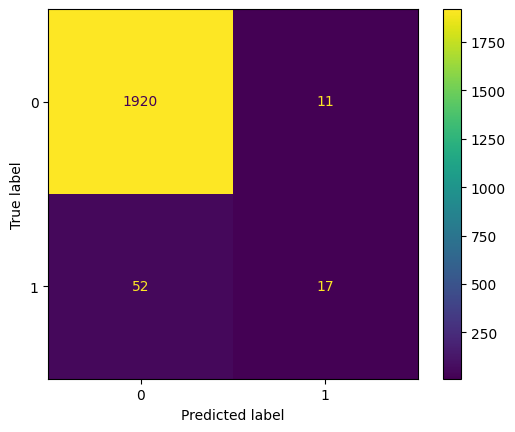

In [27]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

In [28]:
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.9685

In [31]:
# Create 10 new syntetic columns with random values
for i in range(10):
    df[f'random_{i}'] = np.random.rand(df.shape[0])
    

In [32]:
# Select all the columns that are not 'default' or 'student'
X = df.loc[:, ~df.columns.isin(['default', 'student', 'default2', 'student2'])]
y = df.default2


In [33]:
# Divide the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
# Fit the model
X_train_w_intercept = sm.add_constant(X_train)
est = sm.Logit(y_train, X_train_w_intercept).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.074961
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-12.568488,0.681323,-18.447191,5.492735e-76,-13.903855,-11.233120
balance,0.005838,0.000267,21.876507,4.349007e-106,0.005315,0.006362
income,0.000020,0.000006,3.553494,3.801499e-04,0.000009,0.000031
random_0,0.300103,0.275958,1.087496,2.768176e-01,-0.240765,0.840972
random_1,-0.379080,0.269546,-1.406366,1.596155e-01,-0.907381,0.149220
random_2,0.186853,0.280708,0.665649,5.056355e-01,-0.363325,0.737031
random_3,-0.224503,0.274063,-0.819167,4.126911e-01,-0.761657,0.312650
random_4,0.092548,0.267624,0.345815,7.294815e-01,-0.431984,0.617081
random_5,0.227478,0.270507,0.840932,4.003859e-01,-0.302706,0.757662
random_6,0.253971,0.274900,0.923868,3.555550e-01,-0.284823,0.792765


In [35]:
X_test_w_intercept = sm.add_constant(X_test)
y_prob = est.predict(X_test_w_intercept)
y_pred = (y_prob > 0.5).astype(int)


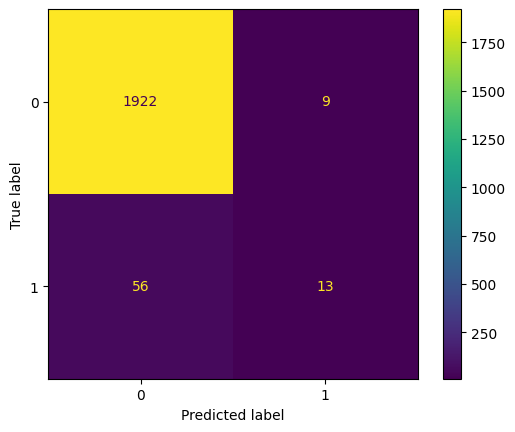

In [36]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [37]:
# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.9675

# Feature Selection
Feature selection is primarily focused on removing non-informative or redundant predictors from the model.



In [ ]:
# Import 